2
7


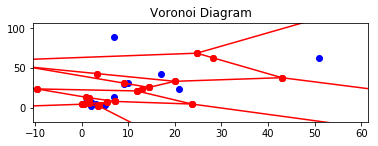

In [2]:
import heapq
import itertools

class Point:
    x = 0.0
    y = 0.0

    def __init__(self, x, y):
        self.x = x
        self.y = y

class Event:
    x = 0.0
    p = None
    a = None
    valid = True

    def __init__(self, x, p, a):
        self.x = x
        self.p = p
        self.a = a
        self.valid = True

class Arc:
    p = None
    pprev = None
    pnext = None
    e = None
    s0 = None
    s1 = None

    def __init__(self, p, a=None, b=None):
        self.p = p
        self.pprev = a
        self.pnext = b
        self.e = None
        self.s0 = None
        self.s1 = None

class Segment:
    start = None
    end = None
    done = False

    def __init__(self, p):
        self.start = p
        self.end = None
        self.done = False

    def finish(self, p):
        if self.done: return
        self.end = p
        self.done = True

class PriorityQueue:
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.counter = itertools.count()

    def push(self, item):
        # check for duplicate
        if item in self.entry_finder: return
        count = next(self.counter)
        # use x-coordinate as a primary key (heapq in python is min-heap)
        entry = [item.x, count, item]
        self.entry_finder[item] = entry
        heapq.heappush(self.pq, entry)

    def remove_entry(self, item):
        entry = self.entry_finder.pop(item)
        entry[-1] = 'Removed'

    def pop(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item is not 'Removed':
                del self.entry_finder[item]
                return item
        raise KeyError('pop from an empty priority queue')

    def top(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item is not 'Removed':
                del self.entry_finder[item]
                self.push(item)
                return item
        raise KeyError('top from an empty priority queue')

    def empty(self):
        return not self.pq

    import random
import math
import matplotlib.pyplot as plt



class Voronoi:
    def __init__(self):
        self.output = [] # list of line segment
        self.arc = None  # binary tree for parabola arcs

        self.points = PriorityQueue() # site events
        self.event = PriorityQueue() # circle events

        # bounding box
        self.x0 = 0
        self.x1 = 0
        self.y0 = 0
        self.y1 = 0

def process(points):

    # insert points to site event
    for pts in points:
        point = Point(pts[0], pts[1])
        arc.points.push(point)
        if point.y < arc.y0: arc.y0 = point.y
        if point.x > arc.x1: arc.x1 = point.x
        if point.y > arc.y1: arc.y1 = point.y

    # add margins to the bounding box
    dx = (arc.x1 - arc.x0 + 1) / 5.0
    dy = (arc.y1 - arc.y0 + 1) / 5.0
    arc.x0 = arc.x0 - dx
    arc.x1 = arc.x1 + dx
    arc.y0 = arc.y0 - dy
    arc.y1 = arc.y1 + dy

    while not arc.points.empty():
        if not arc.event.empty() and (arc.event.top().x <= arc.points.top().x):
            process_event() # handle circle event
        else:
            process_point() # handle site event

    # after all points, process remaining circle events
    while not arc.event.empty():
        process_event()

    finish_edges()

def process_point():
    # get next event from site pq
    p = arc.points.pop()
    # add new arc (parabola)
    arc_insert(p)

def process_event():
    # get next event from circle pq
    e = arc.event.pop()

    if e.valid:
        # start new edge
        s = Segment(e.p)
        arc.output.append(s)

        # remove associated arc (parabola)
        a = e.a
        if a.pprev is not None:
            a.pprev.pnext = a.pnext
            a.pprev.s1 = s
        if a.pnext is not None:
            a.pnext.pprev = a.pprev
            a.pnext.s0 = s

        # finish the edges before and after a
        if a.s0 is not None: a.s0.finish(e.p)
        if a.s1 is not None: a.s1.finish(e.p)

        # recheck circle events on either side of p
        if a.pprev is not None: check_circle_event(a.pprev, e.x)
        if a.pnext is not None: check_circle_event(a.pnext, e.x)

def arc_insert(p):
    if arc.arc is None:
        arc.arc = Arc(p)
    else:
        # find the current arcs at p.y
        i = arc.arc
        while i is not None:
            flag, z = intersect(p, i)
            if flag:
                # new parabola intersects arc i
                flag, zz = intersect(p, i.pnext)
                if (i.pnext is not None) and (not flag):
                    i.pnext.pprev = Arc(i.p, i, i.pnext)
                    i.pnext = i.pnext.pprev
                else:
                    i.pnext = Arc(i.p, i)
                i.pnext.s1 = i.s1

                # add p between i and i.pnext
                i.pnext.pprev = Arc(p, i, i.pnext)
                i.pnext = i.pnext.pprev

                i = i.pnext # now i points to the new arc

                # add new half-edges connected to i's endpoints
                seg = Segment(z)
                arc.output.append(seg)
                i.pprev.s1 = i.s0 = seg

                seg = Segment(z)
                arc.output.append(seg)
                i.pnext.s0 = i.s1 = seg

                # check for new circle events around the new arc
                check_circle_event(i, p.x)
                check_circle_event(i.pprev, p.x)
                check_circle_event(i.pnext, p.x)

                return

            i = i.pnext

        # if p never intersects an arc, append it to the list
        i = arc.arc
        while i.pnext is not None:
            i = i.pnext
        i.pnext = Arc(p, i)

        # insert new segment between p and i
        x = arc.x0
        y = (i.pnext.p.y + i.p.y) / 2.0;
        start = Point(x, y)

        seg = Segment(start)
        i.s1 = i.pnext.s0 = seg
        arc.output.append(seg)

def check_circle_event(i, x0):
    # look for a new circle event for arc i
    if (i.e is not None) and (i.e.x  != arc.x0):
        i.e.valid = False
    i.e = None

    if (i.pprev is None) or (i.pnext is None): return

    flag, x, o = circle(i.pprev.p, i.p, i.pnext.p)
    if flag and (x > arc.x0):
        i.e = Event(x, o, i)
        arc.event.push(i.e)

def circle(a, b, c):
    # check if bc is a "right turn" from ab
    if ((b.x - a.x)*(c.y - a.y) - (c.x - a.x)*(b.y - a.y)) > 0: return False, None, None

    # Joseph O'Rourke, Computational Geometry in C (2nd ed.) p.189
    A = b.x - a.x
    B = b.y - a.y
    C = c.x - a.x
    D = c.y - a.y
    E = A*(a.x + b.x) + B*(a.y + b.y)
    F = C*(a.x + c.x) + D*(a.y + c.y)
    G = 2*(A*(c.y - b.y) - B*(c.x - b.x))

    if (G == 0): return False, None, None # Points are co-linear

    # point o is the center of the circle
    ox = 1.0 * (D*E - B*F) / G
    oy = 1.0 * (A*F - C*E) / G

    # o.x plus radius equals max x coord
    x = ox + math.sqrt((a.x-ox)**2 + (a.y-oy)**2)
    o = Point(ox, oy)

    return True, x, o

def intersect(p, i):
    # check whether a new parabola at point p intersect with arc i
    if (i is None): return False, None
    if (i.p.x == p.x):
        print(i.p.x)
        return False, None

    a = 0.0
    b = 0.0

    if i.pprev is not None:
        a = (intersection(i.pprev.p, i.p, 1.0*p.x)).y
    if i.pnext is not None:
        b = (intersection(i.p, i.pnext.p, 1.0*p.x)).y

    if (((i.pprev is None) or (a <= p.y)) and ((i.pnext is None) or (p.y <= b))):
        py = p.y
        px = 1.0 * ((i.p.x)**2 + (i.p.y-py)**2 - p.x**2) / (2*i.p.x - 2*p.x)
        res = Point(px, py)
        return True, res
    return False, None

def intersection(p0, p1, l):
    # get the intersection of two parabolas
    p = p0
    if (p0.x == p1.x):
        py = (p0.y + p1.y) / 2.0
    elif (p1.x == l):
        py = p1.y
    elif (p0.x == l):
        py = p0.y
        p = p1
    else:
        # use quadratic formula
        z0 = 2.0 * (p0.x - l)
        z1 = 2.0 * (p1.x - l)

        a = 1.0/z0 - 1.0/z1;
        b = -2.0 * (p0.y/z0 - p1.y/z1)
        c = 1.0 * (p0.y**2 + p0.x**2 - l**2) / z0 - 1.0 * (p1.y**2 + p1.x**2 - l**2) / z1

        py = 1.0 * (-b-math.sqrt(b*b - 4*a*c)) / (2*a)

    px = 1.0 * (p.x**2 + (p.y-py)**2 - l**2) / (2*p.x-2*l)
    res = Point(px, py)
    return res

def finish_edges():
    l = arc.x1 + (arc.x1 - arc.x0) + (arc.y1 - arc.y0)
    i = arc.arc
    while i.pnext is not None:
        if i.s1 is not None:
            p = intersection(i.p, i.pnext.p, l*2.0)
            i.s1.finish(p)
        i = i.pnext

def print_output():
    it = 0
    for o in arc.output:
        it = it + 1
        p0 = o.start
        p1 = o.end
        print (p0.x, p0.y, p1.x, p1.y)

def get_output():
    res = []
    for o in arc.output:
        p0 = o.start
        p1 = o.end
        res.append((p0.x, p0.y, p1.x, p1.y))
    return res

#reads in points from file
def read_points(filename):
    xy = []
    with open(filename) as f:
        #reads the data from the file
        for line in f:
            pair = line.split() #reads in line of points
           # self.x.append(int(pair[0]))
           # self.y.append(int(pair[1]))
            temp = (int(pair[0]), int(pair[1])) #assigns points to a tuple
            xy.append(temp) #assigns tuple to xy
        f.close() #closes the file
    return xy

def print_voronoi(points, output = []):
    x, y = [], []
    plt.figure()
    ax = plt.subplot(211)
    plt.title('Voronoi Diagram')
    for point in points:
        x.append(point[0])
        y.append(point[1])
    plt.scatter(x, y, color='blue')
    for i in output:
        xData = [i[0], i[2]]
        yData = [i[1], i[3]]
        plt.plot(xData, yData, 'ro-')
    plt.axis([arc.x0, arc.x1, arc.y0, arc.y1])
    plt.show()

arc = Voronoi()
test = read_points("points")
process(test)
print_voronoi(test, get_output())


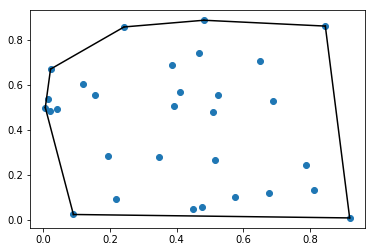

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
points = np.random.rand(30, 2)   # 30 random points in 2-D
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')